In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Copyright © Simphony Project Contributors
# Licensed under the terms of the MIT License
# (see simphony/__init__.py for details)

import os
import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from simphony.library import ebeam, sipann
from simphony.netlist import Subcircuit
from simphony.simulation import SweepSimulation, freq2wl

In [2]:
# Have a main data line where frequency multiplexed data enters the circuit.
wg_data = ebeam.ebeam_wg_integral_1550(100e-6)

# A terminator for dispersing unused light
term = ebeam.ebeam_terminator_te1550()

def ring_factory(radius):
    """
    Creates a full ring (with terminator) from a half ring.

    Ports of a half ring are ordered like so:
    2           4
     |         |
      \       /
       \     /
     ---=====---
    1           3

    Resulting pins are ('in', 'out', 'pass').

    Parameters
    ----------
    radius : float
        The radius of the ring resonator, in microns.
    """
    # Have rings for selecting out frequencies from the data line.
    half_ring = sipann.sipann_scee_halfring(radius=radius)

    circuit = Subcircuit()
    circuit.add([
        (half_ring, 'input'),
        (half_ring, 'output'),
        (term, 'terminator')
    ])

    circuit.elements['input'].pins = ('pass', 'midb', 'in', 'midt')
    circuit.elements['output'].pins = ('out', 'midt', 'term', 'midb')
    
    circuit.connect_many([
        ('input', 'midb', 'output', 'midb'),
        ('input', 'midt', 'output', 'midt'),
        ('terminator', 'n1', 'output', 'term')
    ])

    return circuit

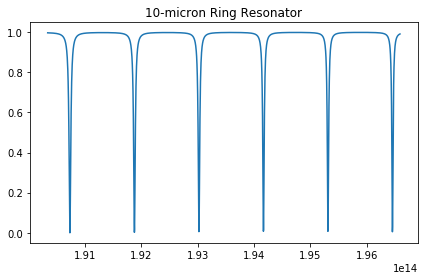

In [5]:
# Behold, we can run a simulation on a single ring resonator.
cir1 = ring_factory(10)
sim1 = SweepSimulation(cir1, 1525e-9, 1575e-9)
res1 = sim1.simulate()

f1, s = res1.data(res1.pinlist['in'], res1.pinlist['pass'])
plt.plot(f1, s)
plt.title("10-micron Ring Resonator")
plt.tight_layout()
plt.show()